# Different implementations of a Marine Data Science application

For a given sea level field `ssh`, we want to calculate the domain-wide spatial average of kinetic energy (via geostrophic surface velocities).
We want this `ssh` field to live on a torus (which implies cyclic boundary conditions in, both, y and x).

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# parameters
rng_seed = 12345
Nt = 30  # number of time steps
Ny = 20  # number of grid points in y
Nx = 10  # number of grid points in x
dy = 200e3  # grid constant in y (in meters)
dx = 400e3  # grid constant in x (in meters)
g0 = 9.81  # graviational acceleration (in meters / second^2)
f0 = 2 * 7.2921e-5 * 0.5  # Coriolis parameter (in 1/second) at 30 N

In [3]:
t = np.arange(Nt)  # time vector
y = np.arange(Ny) * dy  # positions in y
x = np.arange(Nx) * dx  # positions in x

# chose a random sea level field
np.random.seed(rng_seed)
ssh = 3 * np.random.normal(size=(Nt, Ny, Nx))

## Implemetation 1

In [4]:
def energy_average_1(ssh, x, y, t, g=g0, f=f0):
    # get grid constant
    dy = y[1] - y[0]
    dx = x[1] - x[0]
    
    # calculate u and v using geostrophy
    u = - g / f * np.diff(ssh[:, np.arange(-1, y.size), :], axis=1) / dy
    v = g / f * np.diff(ssh[:, :, np.arange(-1, x.size)], axis=2) / dx
    
    # calculate energy
    e = 0.5 * (u ** 2 + v ** 2)
    
    # average energy in x and y
    e_ave = e.mean(axis=-1).mean(axis=-1)
    
    return e_ave

## Implemetation 2

In [5]:
def energy_average_2(ssh, x, y, t, g=g0, f=f0):
    # get grid constant
    dy = y[1] - y[0]
    dx = x[1] - x[0]
    
    # calculate u and v using geostrophy
    u = -g / f * np.diff(ssh[:, :, :-1], axis=1) / dy
    v = g / f * np.diff(ssh[:, :-1, :], axis=2) / dx
    
    # calculate energy
    e = 0.5 * (u ** 2 + v ** 2)
    
    # average energy in x and y
    e_ave = e.mean(axis=-1).mean(axis=-1)
    
    return e_ave

## Compare implementations

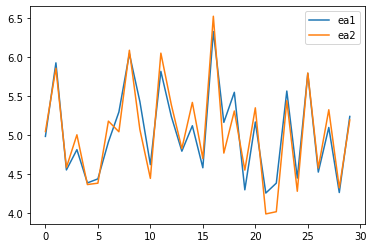

In [6]:
plt.plot(t, energy_average_1(ssh, x, y, t, g=g0, f=f0), label="ea1");
plt.plot(t, energy_average_2(ssh, x, y, t, g=g0, f=f0), label="ea2");
plt.gca().legend();

In [7]:
print(np.allclose(
    energy_average_1(ssh, x, y, t, g=g0, f=f0),
    energy_average_2(ssh, x, y, t, g=g0, f=f0)
))

False


## Check metamorphic relations for implementation 1

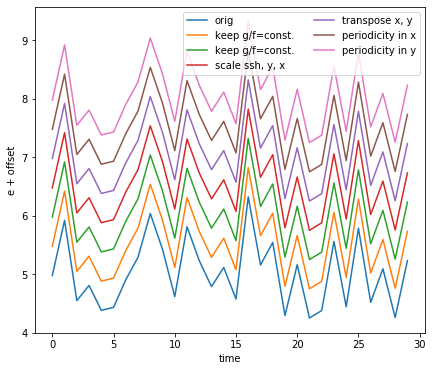

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6)) 
ax.plot(t, energy_average_1(ssh, x, y, t, g=g0, f=f0), label="orig")
ax.plot(t, energy_average_1(ssh, x, y, t, g=g0 * 5, f=f0 * 5) + 0.5, label="keep g/f=const.")
ax.plot(t, energy_average_1(ssh, x, y, t, g=1, f=f0/g0) + 1.0, label="keep g/f=const.")
ax.plot(t, energy_average_1(7 * ssh, 7 * x, 7 * y, t) + 1.5, label="scale ssh, y, x")
ax.plot(t, energy_average_1(ssh.transpose([0, 2, 1]), x=y, y=x, t=t) + 2.0, label="transpose x, y")
ax.plot(t, energy_average_1(np.roll(ssh, 7, axis=-1), x=np.roll(x, 7), y=y, t=t, g=g0, f=f0) + 2.5, label="periodicity in x")
ax.plot(t, energy_average_1(np.roll(ssh, 7, axis=-2), x=x, y=np.roll(y, 7), t=t, g=g0, f=f0) + 3.0, label="periodicity in y")
ax.set_xlabel("time")
ax.set_ylabel("e + offset")
ax.legend(ncol=2);

## Check metamorphic relations for implementation 2

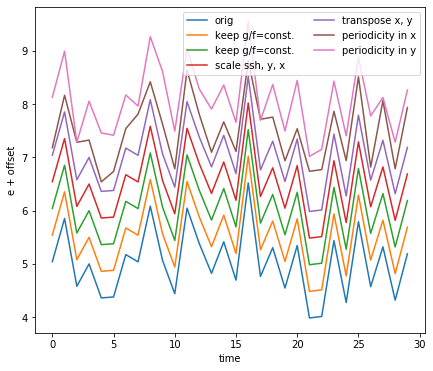

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6)) 
ax.plot(t, energy_average_2(ssh, x, y, t, g=g0, f=f0), label="orig")
ax.plot(t, energy_average_2(ssh, x, y, t, g=g0 * 5, f=f0 * 5) + 0.5, label="keep g/f=const.")
ax.plot(t, energy_average_2(ssh, x, y, t, g=1, f=f0/g0) + 1.0, label="keep g/f=const.")
ax.plot(t, energy_average_2(7 * ssh, 7 * x, 7 * y, t) + 1.5, label="scale ssh, y, x")
ax.plot(t, energy_average_2(ssh.transpose([0, 2, 1]), x=y, y=x, t=t) + 2.0, label="transpose x, y")
ax.plot(t, energy_average_2(np.roll(ssh, 7, axis=-1), x=np.roll(x, 7), y=y, t=t, g=g0, f=f0) + 2.5, label="periodicity in x")
ax.plot(t, energy_average_2(np.roll(ssh, 7, axis=-2), x=x, y=np.roll(y, 7), t=t, g=g0, f=f0) + 3.0, label="periodicity in y")
ax.set_xlabel("time")
ax.set_ylabel("e + offset")
ax.legend(ncol=2);

And we find that `energy_average_2()` does not account for cyclicity.